In [1]:
import keras
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from sklearn.model_selection import KFold as KF
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
import os,cv2
%matplotlib inline

Using TensorFlow backend.


### 模型导入、定义

In [2]:
base_model = VGG16(weights='imagenet',include_top=False)
# 获取各层的输出：
layer_outputs = [layer.output for layer in base_model.layers[2:20]]
# 获取各层的名称：
layer_names = []
for layer in base_model.layers[2:20]:
    layer_names.append(layer.name)
print(layer_names)

['block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']


In [3]:
# 组装模型：
model = Model(inputs=base_model.input, outputs=layer_outputs)

### 先使用 block3_conv1 层的特征

In [4]:
# layer_features=activations[5]
# layer_features.shape

### 拼接矩阵，56 * 56 * 256的 3D 矩阵拼接成 256 * 3136  的 2D 矩阵

In [5]:
def conj_martix(martix):
    result=[]
    width=martix.shape[0]
    height=martix.shape[1]
    nums=martix.shape[2]
    for num in range(nums):
        result.append(martix[:,:,num].flatten())
    return result

### 降采样矩阵

In [6]:
from numpy import nanmean
def downsample(myarr,factor,estimator=nanmean):
    """
    Downsample a 2D array by averaging over *factor* pixels in each axis.
    Crops upper edge if the shape is not a multiple of factor.
    This code is pure np and should be fast.
    keywords:
        estimator - default to mean.  You can downsample by summing or
            something else if you want a different estimator
            (e.g., downsampling error: you want to sum & divide by sqrt(n))
    """
    ys,xs = myarr.shape
    crarr = myarr[:ys-(ys % int(factor)),:xs-(xs % int(factor))]
    dsarr = estimator( np.concatenate([[crarr[i::factor,j::factor] 
        for i in range(factor)] 
        for j in range(factor)]), axis=0)
    return dsarr

### 取格雷姆矩阵的上半区

In [17]:
def upper_gram(metrix):
    features=[]
    gram_len=metrix.shape[1]
    for row in range(gram_len):
        for clo in range(gram_len):
            clos=clo+row
            if(clos>gram_len-1):
                break
            features.append((metrix[row][row+clo]))
    return np.array(features)

### 导入数据

In [ ]:
data_path = '../../jaffe/'
data_dir_list = os.listdir(data_path)
img_data_list=[]

for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        input_img_resize=cv2.resize(input_img,(224,224))
        img_data_list.append(input_img_resize)
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

### 打上标签

In [ ]:
num_classes = 7#生气、厌恶、恐惧、快乐、没啥表情、伤心、吃惊

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:32]=0 #32
labels[32:62]=1 #30
labels[62:92]=2 #30
labels[92:121]=3 #29
labels[121:152]=4 #31
labels[152:183]=5 #31
labels[183:]=6 #30

names = ['FEAR','SURPRISE','NEUTRAL','DISGUST','SAD','HAPPY','ANGRY']

def getLabel(id):
    return ['FEAR','SURPRISE','NEUTRAL','DISGUST','SAD','HAPPY','ANGRY'][id]
Y=labels
Y.shape

In [ ]:
# indices = np.random.randint(0, len(img_data)-1, 2)#随机取 10 张图片
# for i,im in enumerate(img_data[indices,:,:]):
#     plt.subplot(1, len(indices), i+1)
#     plt.imshow(im, cmap='gray')
#     plt.xticks(())
#     plt.yticks(())
#     plt.title('IMG-' + str(indices[i])+"-"+names[labels[indices[i]]])
# plt.show()

### 获取图像对应的 CNN 中间层特征

In [ ]:
def get_features(origin_features,layers):
    features_mertix=[]
    for index in range(origin_features.shape[0]):
        cnn_featues=model.predict(origin_features[index:index+1,:,:,:])
        layer_features=cnn_featues[layers][0]#获取第三层的输出
        conj_mertix=np.array(conj_martix(layer_features))#拼接矩阵
#         down_sample_features=downsample(conj_mertix,downsample_ratio)#降采样
        gram_metrix=np.dot(conj_mertix, conj_mertix.T)#计算 gram 矩阵`
        feature=upper_gram(gram_metrix)#取 gram 矩阵的上半区
        features_mertix.append(feature)
    return np.array(features_mertix)

### 生成数据

In [ ]:
features=get_features(img_data,9)

### SVM 支持向量

#### SVM 交叉验证

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
from sklearn.svm import SVC
clf = SVC()
scores = cross_val_score(clf, features, labels, cv=10)
print(scores.mean())

### KNN K 近邻算法

#### KNN 交叉验证

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as KNN
knn = KNN(n_neighbors=1)
scores = cross_val_score(knn, features, labels, cv=10)
print(scores.mean())

### 随机森林

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
scores = cross_val_score(rf, features, labels, cv=10)
print(scores.mean())

### 特征图举例

(1, 224, 224, 3)

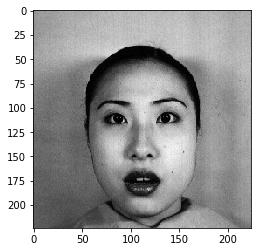

In [39]:
img_path = '../../jaffe/SURPRISE/surprise10.jpg'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x.shape

In [40]:
X=model.predict(x[0:1,:,:,:])
layer_features=X[13][0]
conj_mertix=np.array(conj_martix(layer_features))#拼接矩阵
# down_sample_features=downsample(conj_mertix,8)#降采样
gram_metrix=np.dot(conj_mertix,conj_mertix.T)#计算 gram 矩阵`
feature=upper_gram(gram_metrix)#取 gram 矩阵的上半区

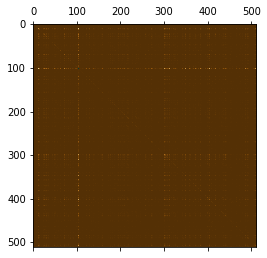

In [41]:
import matplotlib.pyplot as plt
plt.matshow(gram_metrix, cmap='BrBG')
plt.show()